# Geographic Visualizations for Paper

This notebook creates publication-quality maps:
1. **Current hotspot heatmap** - Where crashes are concentrated now
2. **Predicted hotspot map** - Model predictions for future hotspots
3. **Community area choropleth** - Crash rates by neighborhood
4. **Comparison maps** - Current vs. predicted side-by-side

These visualizations will be used in your paper's Results section.

In [10]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches

pd.set_option('display.max_columns', 120)
sns.set_style('white')

# Paths
DATA_DIR = Path('../data/processed')
RAW_DIR = Path('../data/raw')
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

## 1. Load Data

In [11]:
# Load intersection features
feats = pd.read_parquet(DATA_DIR / 'intersection_features_enriched.parquet')

# Load OSM nodes for coordinates - use gpd.read_parquet to preserve GeoDataFrame
nodes = gpd.read_parquet(DATA_DIR / 'osm_nodes.parquet')

print(f"Features shape: {feats.shape}")
print(f"Nodes shape: {nodes.shape}")
print(f"Nodes columns: {nodes.columns.tolist()}")

# Check if nodes have geometry column
if 'geometry' in nodes.columns:
    print("✅ Nodes have geometry column - using existing geometry")
    # Use existing geometry from nodes
    spatial_data = feats.merge(
        nodes[['node_id', 'geometry']], 
        left_on='intersection_id', 
        right_on='node_id',
        how='left'
    )
    # Create GeoDataFrame with existing geometry
    # Get CRS from nodes if available, otherwise use EPSG:26971
    node_crs = nodes.crs if hasattr(nodes, 'crs') and nodes.crs is not None else 'EPSG:26971'
    gdf = gpd.GeoDataFrame(spatial_data, geometry='geometry', crs=node_crs)
else:
    print("⚠️  No geometry column - creating from x, y coordinates")
    # Merge coordinates
    spatial_data = feats.merge(
        nodes[['node_id', 'x', 'y']], 
        left_on='intersection_id', 
        right_on='node_id',
        how='left'
    ).dropna(subset=['x', 'y'])
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        spatial_data,
        geometry=gpd.points_from_xy(spatial_data.x, spatial_data.y),
        crs='EPSG:26971'
    )

# Diagnostic: Check coordinate ranges
print(f"\nGeometry check:")
print(f"  CRS: {gdf.crs}")
print(f"  X range: {gdf.geometry.x.min():.0f} to {gdf.geometry.x.max():.0f}")
print(f"  Y range: {gdf.geometry.y.min():.0f} to {gdf.geometry.y.max():.0f}")
print(f"  Valid geometries: {gdf.geometry.notna().sum():,} / {len(gdf):,}")

# Load community area boundaries
import zipfile

try:
    zip_path = RAW_DIR / 'community_areas.zip'
    extract_dir = RAW_DIR / 'community_areas_extracted'
    
    # Extract zip if needed
    if not extract_dir.exists():
        print(f"Extracting community boundaries from {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✅ Extracted to {extract_dir}")
    
    # Find shapefile
    shp_files = list(extract_dir.glob('*.shp'))
    if shp_files:
        community_boundaries = gpd.read_file(shp_files[0])
        community_boundaries = community_boundaries.to_crs('EPSG:26971')
        print(f"✅ Loaded community boundaries: {len(community_boundaries)} areas")
        HAS_BOUNDARIES = True
    else:
        raise FileNotFoundError("No .shp file found in extracted directory")
except Exception as e:
    print(f"⚠️  Community boundaries not found: {e}")
    print("   Maps will show points only (no boundaries).")
    HAS_BOUNDARIES = False

print(f"\nIntersections: {len(gdf):,}")
print(f"Current hotspots: {gdf['label_hotspot'].sum():,}")
print(f"Future crashes: {gdf['future_crashes'].sum():,.0f}")

Features shape: (19200, 32)
Nodes shape: (29366, 9)
Nodes columns: ['node_id', 'y', 'x', 'street_count', 'highway', 'ref', 'junction', 'railway', 'geometry']
✅ Nodes have geometry column - using existing geometry

Geometry check:
  CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "NAD83 / Illinois East", "base_crs": {"name": "NAD83", "datum": {"type": "GeodeticReferenceFrame", "name": "North American Datum 1983", "ellipsoid": {"name": "GRS 1980", "semi_major_axis": 6378137, "inverse_flattening": 298.257222101}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "id": {"authority": "EPSG", "code": 4269}}, "conversion": {"name": "SPCS83 Illinois East zone (meters)", "method": {"name": "Transverse Mercator", "id": {"authority": "EPSG", "code"

## 2. Current Hotspot Map

✅ Saved: results/map_current_hotspots.png


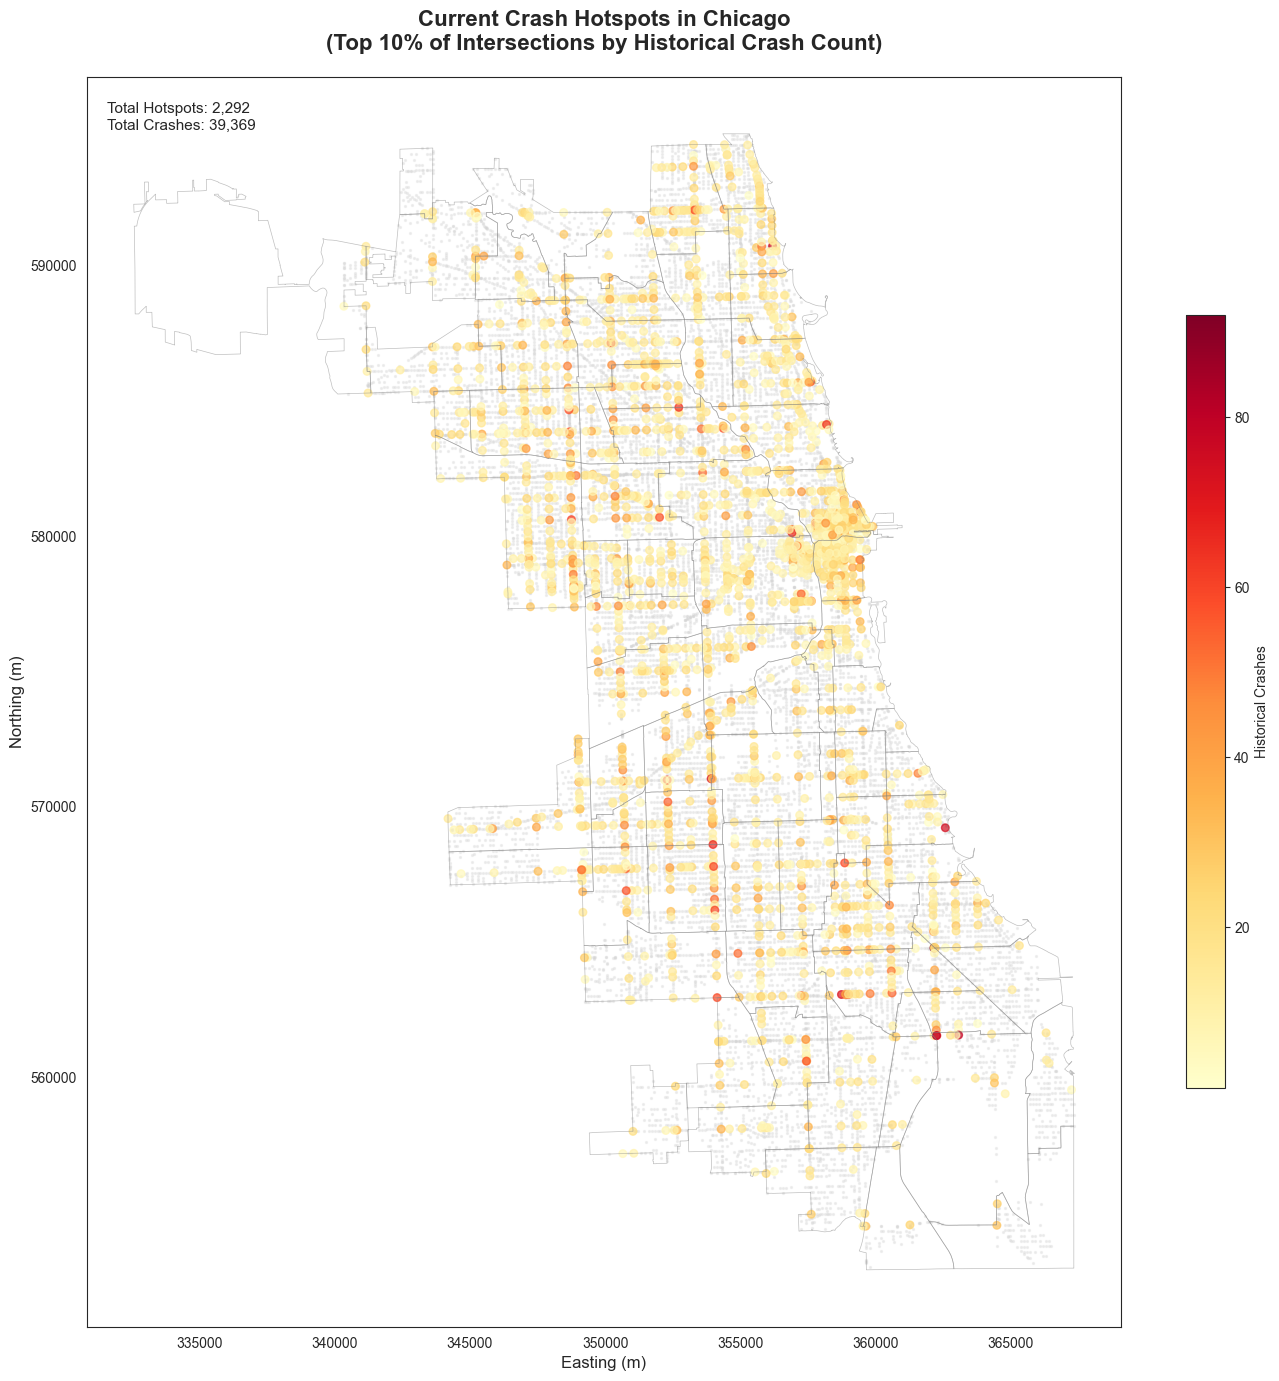

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Plot community boundaries if available
if HAS_BOUNDARIES:
    community_boundaries.boundary.plot(ax=ax, linewidth=0.5, edgecolor='gray', alpha=0.5)

# Plot non-hotspots (small, light)
non_hotspots = gdf[gdf['label_hotspot'] == 0]
non_hotspots.plot(
    ax=ax, 
    markersize=2, 
    color='lightgray', 
    alpha=0.3,
    label='Non-Hotspot'
)

# Plot hotspots (larger, colored by crash count)
hotspots = gdf[gdf['label_hotspot'] == 1]
hotspots.plot(
    ax=ax,
    column='hist_crashes',
    cmap='YlOrRd',
    markersize=30,
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'Historical Crashes', 'shrink': 0.6}
)

ax.set_title('Current Crash Hotspots in Chicago\n(Top 10% of Intersections by Historical Crash Count)',
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)
ax.set_aspect('equal')

# Add text annotation
ax.text(0.02, 0.98, f'Total Hotspots: {len(hotspots):,}\nTotal Crashes: {hotspots["hist_crashes"].sum():,.0f}',
       transform=ax.transAxes, fontsize=11, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'map_current_hotspots.png', dpi=300, bbox_inches='tight')
print("✅ Saved: results/map_current_hotspots.png")
plt.show()

## 3. Load Model Predictions

We'll load predictions from the temporal model to show predicted future hotspots.

In [13]:
# Load model predictions from the full predictions file
try:
    # Load the FULL predictions file (not just top 20)
    predictions_df = pd.read_parquet(DATA_DIR / 'intersection_predictions.parquet')
    print(f"✅ Loaded predictions for {len(predictions_df):,} intersections")
    
    # Merge with spatial data
    gdf_with_predictions = gdf.merge(
        predictions_df[['intersection_id', 'predicted_probability', 'predicted_hotspot']],
        on='intersection_id',
        how='left'
    )
    
    # Fill NaN with 0 for any unmatched intersections
    gdf_with_predictions['predicted_probability'] = gdf_with_predictions['predicted_probability'].fillna(0)
    gdf_with_predictions['predicted_hotspot'] = gdf_with_predictions['predicted_hotspot'].fillna(0).astype(int)
    
    HAS_PREDICTIONS = True
    
except FileNotFoundError:
    print("⚠️  No predictions found. Run modeling notebook (02_modeling_executed.ipynb) first.")
    print("   Creating synthetic predictions for demonstration...")
    
    # Create synthetic predictions based on historical crashes
    gdf_with_predictions = gdf.copy()
    gdf_with_predictions['predicted_probability'] = (
        gdf_with_predictions['hist_crashes'] / gdf_with_predictions['hist_crashes'].max()
    )
    # Use top 10% as hotspots
    threshold = gdf_with_predictions['predicted_probability'].quantile(0.90)
    gdf_with_predictions['predicted_hotspot'] = (
        gdf_with_predictions['predicted_probability'] >= threshold
    ).astype(int)
    HAS_PREDICTIONS = False

# Validation checks
print("\n📊 Validation Checks:")
assert len(gdf_with_predictions) == len(gdf), "❌ Lost data in merge"
assert gdf_with_predictions['predicted_probability'].notna().all(), "❌ Missing predictions"
assert 0 <= gdf_with_predictions['predicted_probability'].max() <= 1, "❌ Invalid probabilities"

print(f"✅ Predictions loaded: {len(gdf_with_predictions):,}")
print(f"✅ Probability range: [{gdf_with_predictions['predicted_probability'].min():.3f}, "
      f"{gdf_with_predictions['predicted_probability'].max():.3f}]")

print(f"\nPredicted hotspots: {gdf_with_predictions['predicted_hotspot'].sum():,}")
print(f"Predicted hotspot rate: {gdf_with_predictions['predicted_hotspot'].mean()*100:.1f}%")
if HAS_PREDICTIONS:
    print(f"Actual hotspots: {gdf_with_predictions['label_hotspot'].sum():,}")
    print(f"Actual hotspot rate: {gdf_with_predictions['label_hotspot'].mean()*100:.1f}%")

✅ Loaded predictions for 19,200 intersections

📊 Validation Checks:
✅ Predictions loaded: 19,200
✅ Probability range: [0.001, 0.996]

Predicted hotspots: 2,332
Predicted hotspot rate: 12.1%
Actual hotspots: 2,292
Actual hotspot rate: 11.9%


## 4. Predicted Hotspot Map

✅ Saved: results/map_predicted_hotspots.png


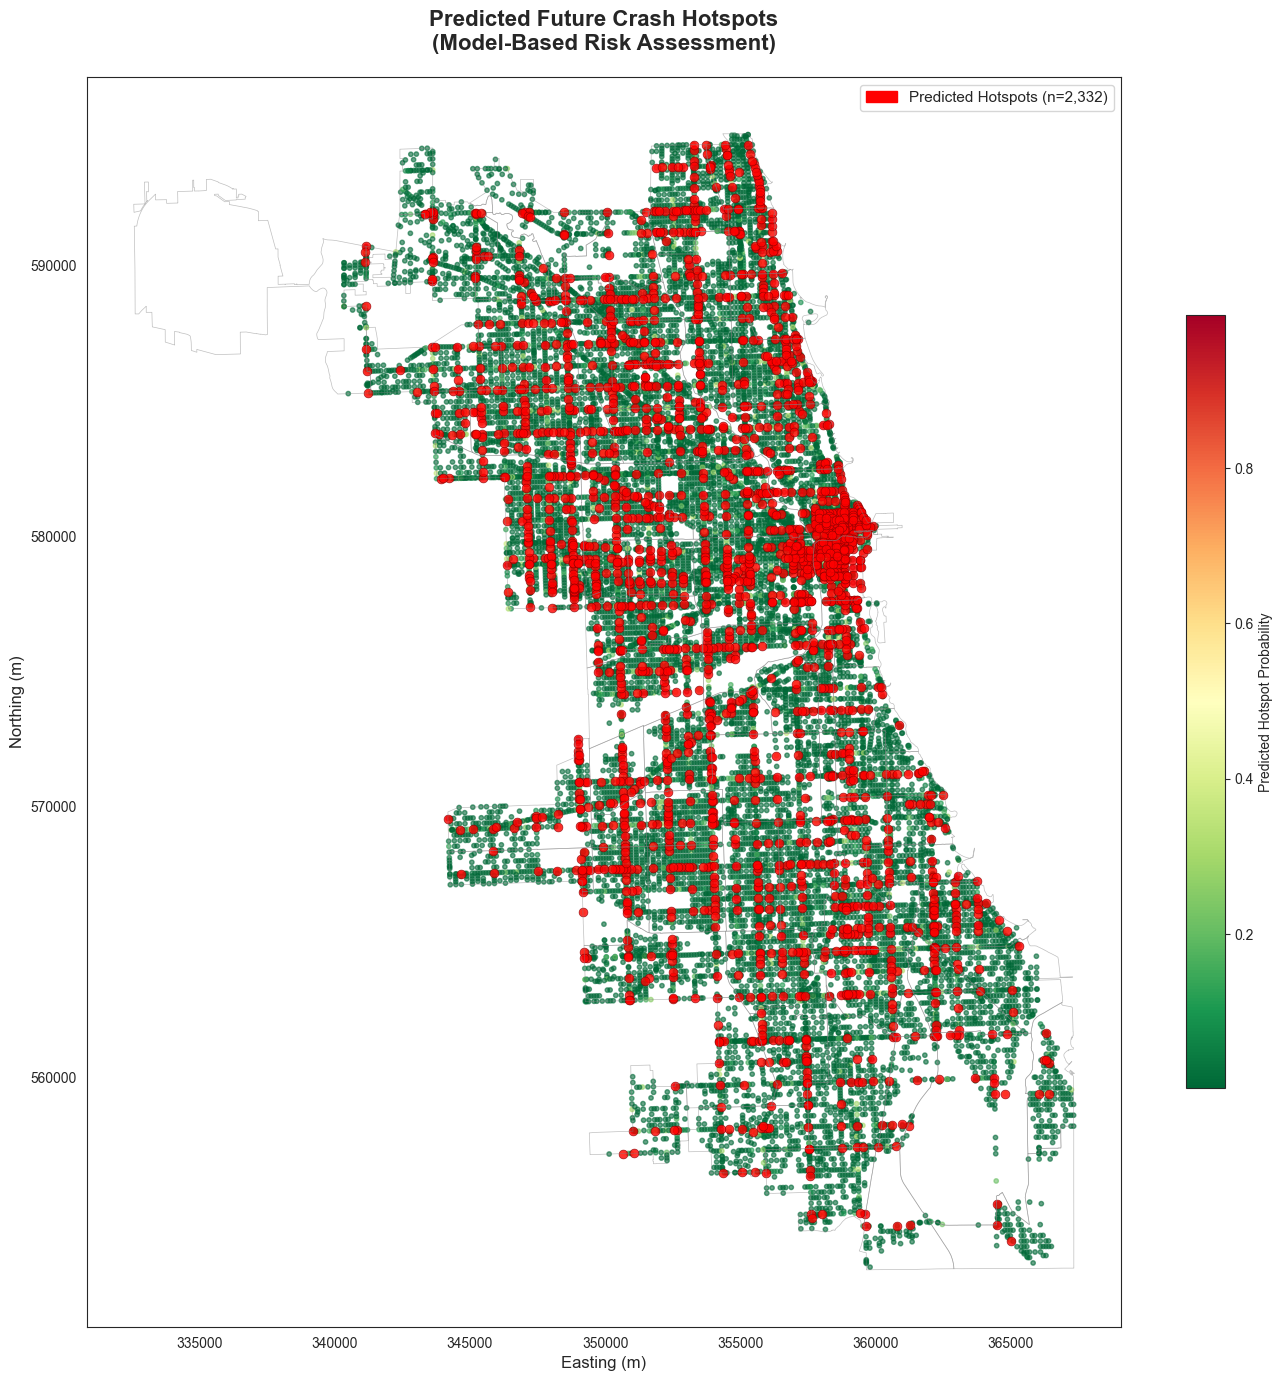

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Plot community boundaries
if HAS_BOUNDARIES:
    community_boundaries.boundary.plot(ax=ax, linewidth=0.5, edgecolor='gray', alpha=0.5)

# Plot all intersections by prediction probability
gdf_with_predictions.plot(
    ax=ax,
    column='predicted_probability',
    cmap='RdYlGn_r',  # Red = high risk, Green = low risk
    markersize=10,
    alpha=0.6,
    legend=True,
    legend_kwds={'label': 'Predicted Hotspot Probability', 'shrink': 0.6}
)

# Highlight top predicted hotspots
predicted_hot = gdf_with_predictions[gdf_with_predictions['predicted_hotspot'] == 1]
predicted_hot.plot(
    ax=ax,
    markersize=40,
    color='red',
    alpha=0.8,
    edgecolor='darkred',
    linewidth=0.5
)

ax.set_title('Predicted Future Crash Hotspots\n(Model-Based Risk Assessment)',
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)
ax.set_aspect('equal')

# Add legend for predicted hotspots
red_patch = mpatches.Patch(color='red', label=f'Predicted Hotspots (n={len(predicted_hot):,})')
ax.legend(handles=[red_patch], loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'map_predicted_hotspots.png', dpi=300, bbox_inches='tight')
print("✅ Saved: results/map_predicted_hotspots.png")
plt.show()

## 4.5. Comparison Map: Current vs Predicted

Side-by-side comparison of current and predicted hotspots.


✅ Saved: results/map_comparison_current_vs_predicted.png


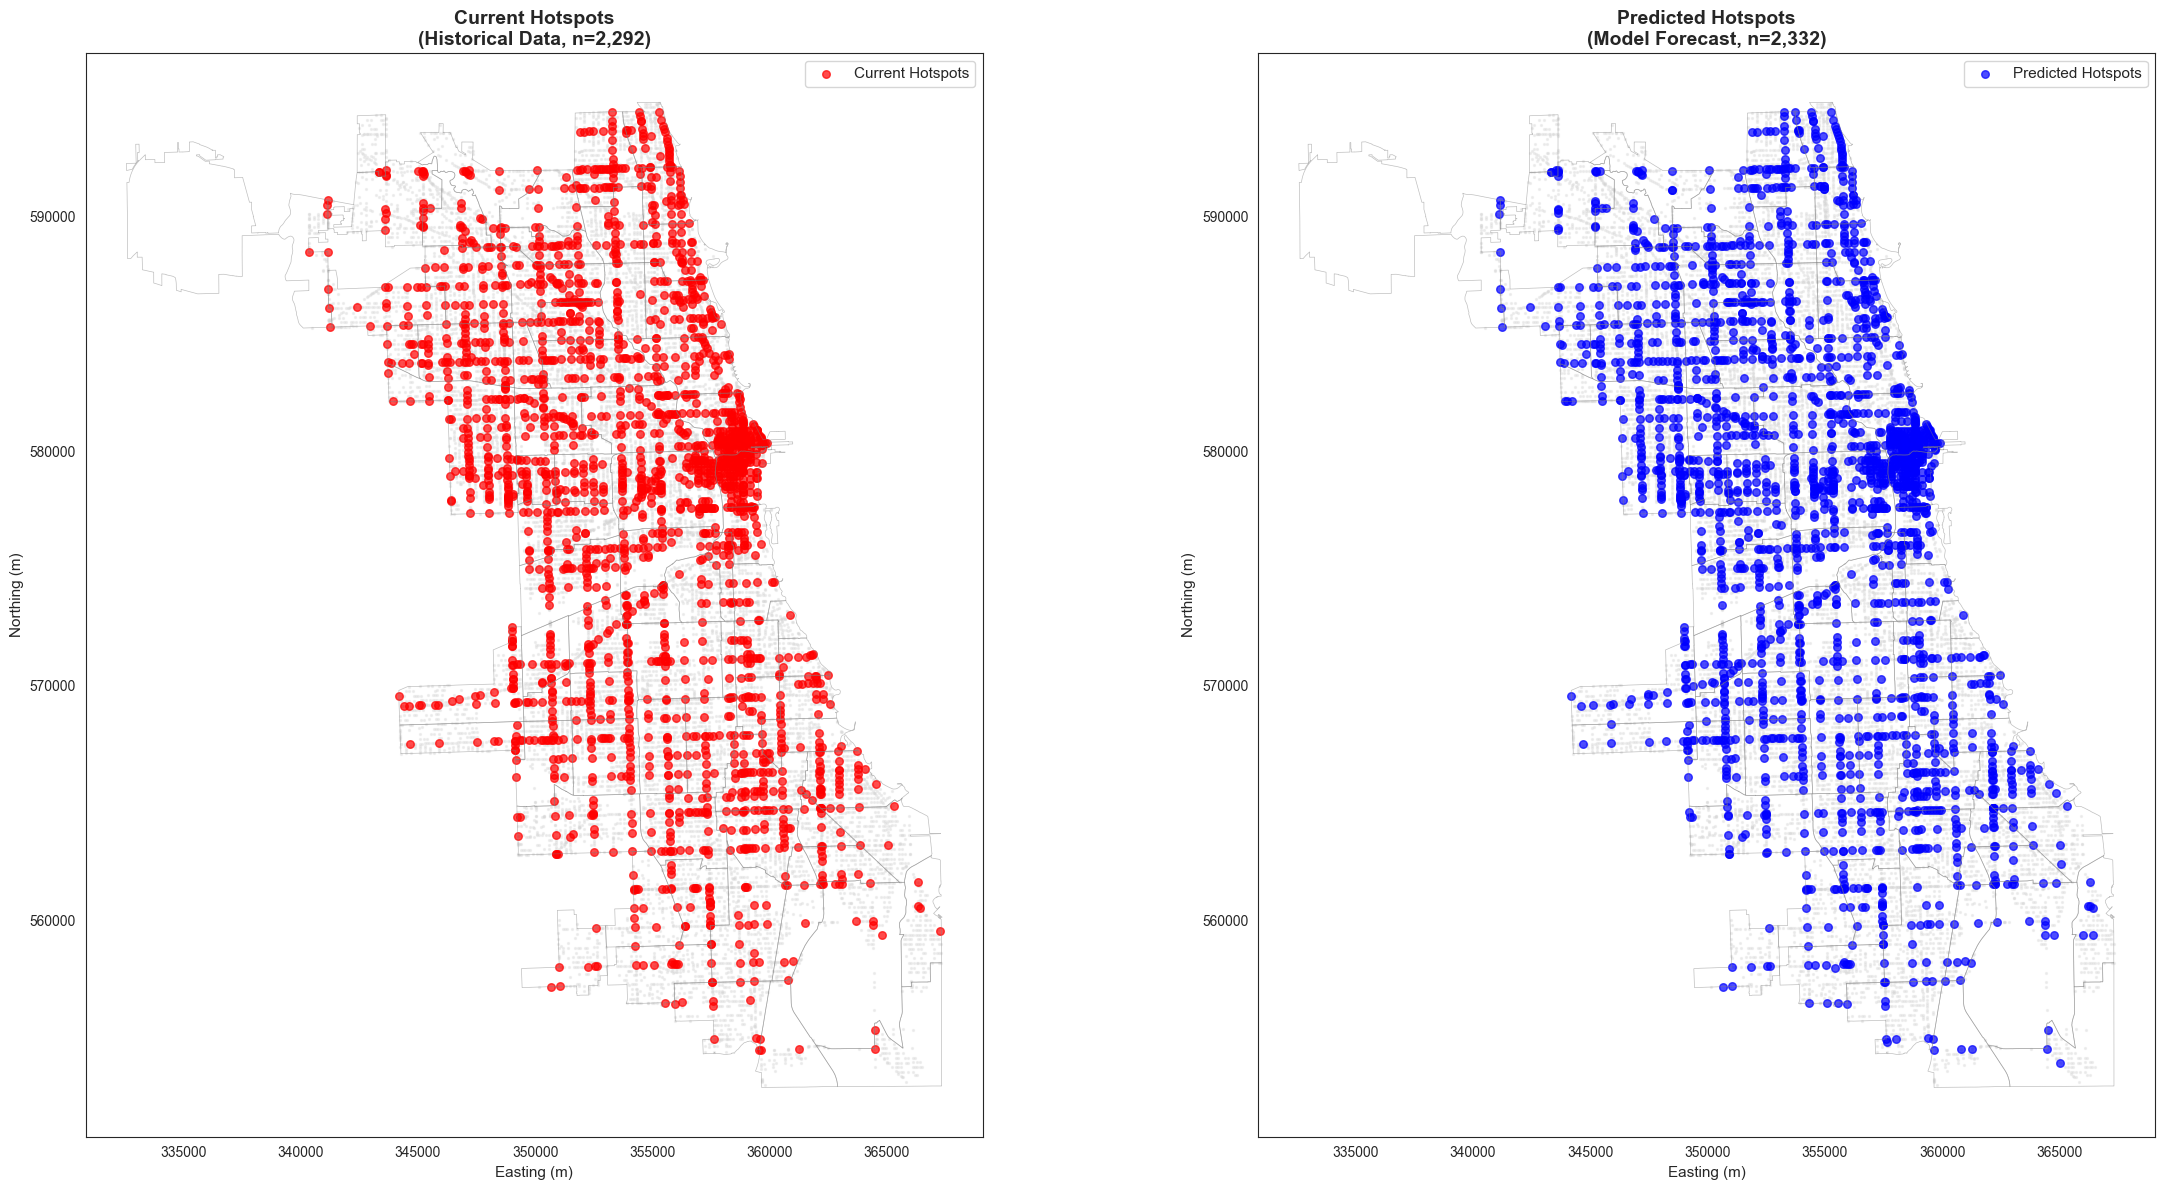

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Left: Current hotspots
if HAS_BOUNDARIES:
    community_boundaries.boundary.plot(ax=axes[0], linewidth=0.5, edgecolor='gray', alpha=0.5)

gdf[gdf['label_hotspot'] == 0].plot(
    ax=axes[0], markersize=2, color='lightgray', alpha=0.3)
gdf[gdf['label_hotspot'] == 1].plot(
    ax=axes[0], markersize=30, color='red', alpha=0.7, label='Current Hotspots')

axes[0].set_title(f'Current Hotspots\n(Historical Data, n={gdf["label_hotspot"].sum():,})', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Easting (m)', fontsize=11)
axes[0].set_ylabel('Northing (m)', fontsize=11)
axes[0].legend(loc='upper right', fontsize=11)
axes[0].set_aspect('equal')

# Right: Predicted hotspots
if HAS_BOUNDARIES:
    community_boundaries.boundary.plot(ax=axes[1], linewidth=0.5, edgecolor='gray', alpha=0.5)

gdf_with_predictions[gdf_with_predictions['predicted_hotspot'] == 0].plot(
    ax=axes[1], markersize=2, color='lightgray', alpha=0.3)
gdf_with_predictions[gdf_with_predictions['predicted_hotspot'] == 1].plot(
    ax=axes[1], markersize=30, color='blue', alpha=0.7, label='Predicted Hotspots')

axes[1].set_title(f'Predicted Hotspots\n(Model Forecast, n={gdf_with_predictions["predicted_hotspot"].sum():,})', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Easting (m)', fontsize=11)
axes[1].set_ylabel('Northing (m)', fontsize=11)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'map_comparison_current_vs_predicted.png', dpi=300, bbox_inches='tight')
print("✅ Saved: results/map_comparison_current_vs_predicted.png")
plt.show()


## 5. Community Area Choropleth Map

✅ Saved: results/map_community_choropleth.png


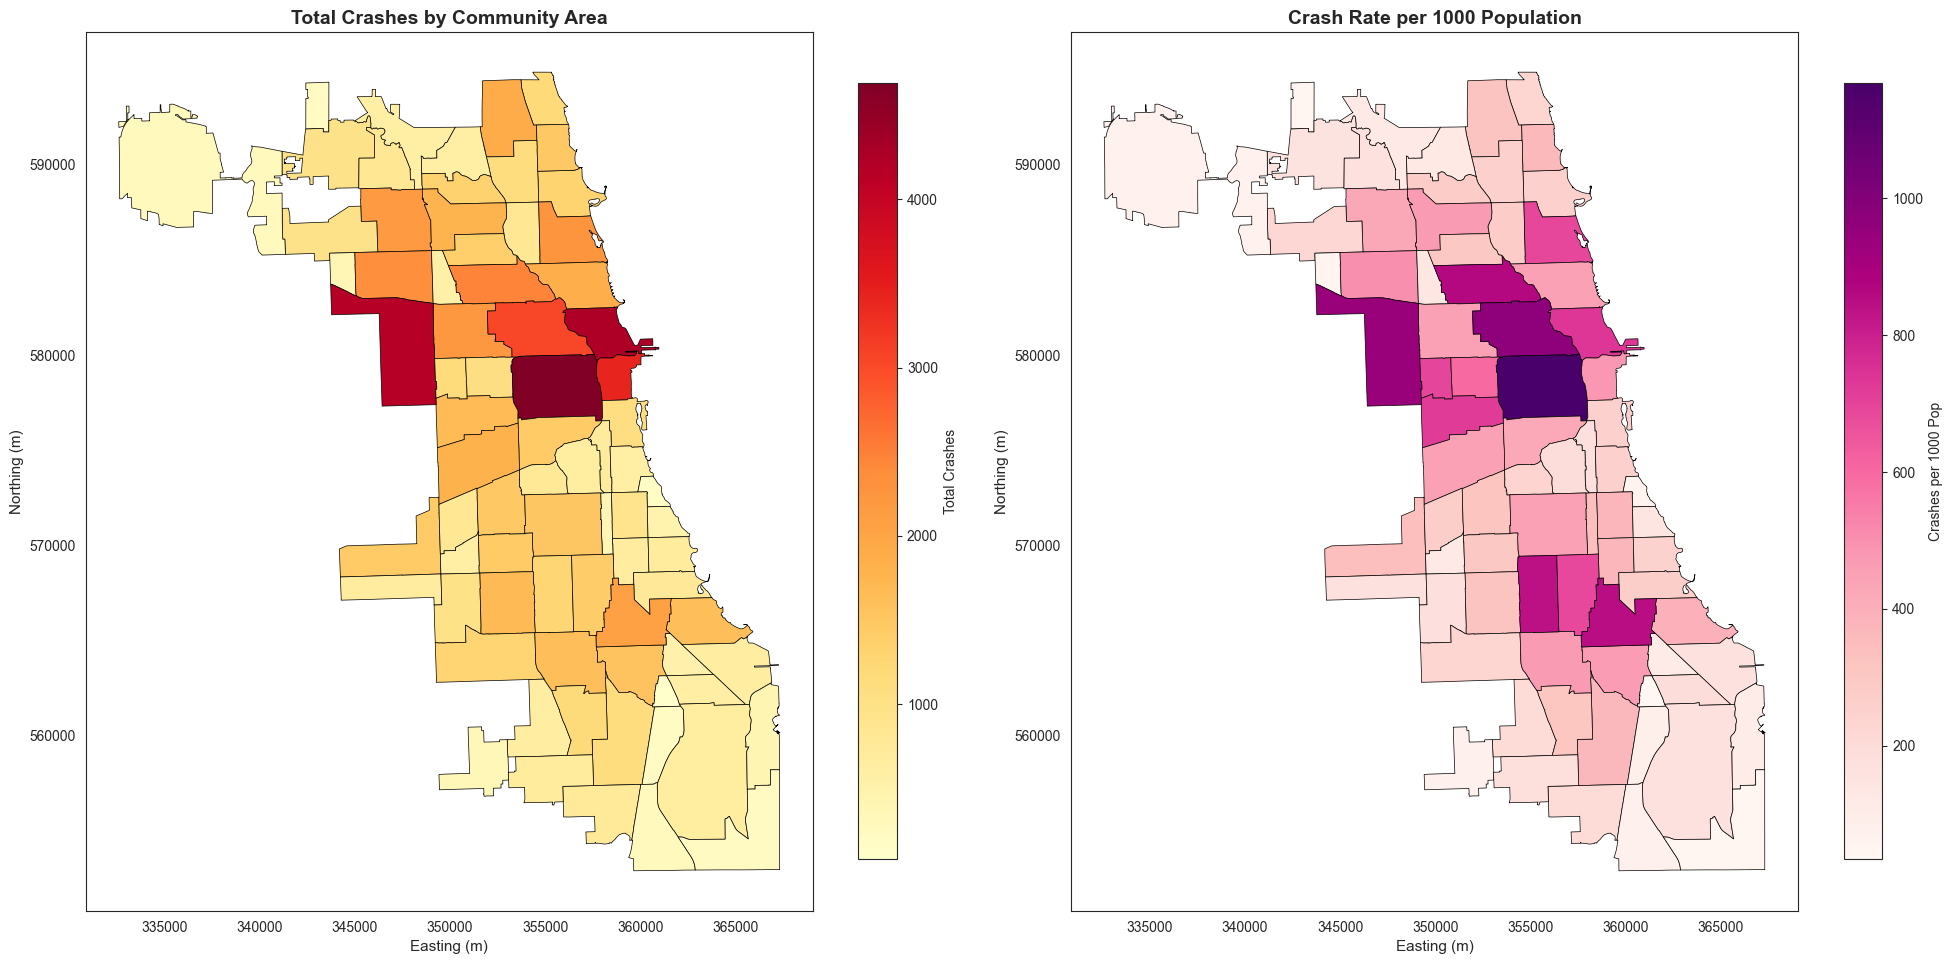

In [16]:
if HAS_BOUNDARIES:
    # Aggregate crashes by community area
    community_crashes = gdf.groupby('community_name').agg({
        'hist_crashes': 'sum',
        'label_hotspot': 'sum',
        'acs_pop': 'mean'
    }).reset_index()
    
    # Calculate crash rate per 1000 population
    community_crashes['crash_rate'] = (
        community_crashes['hist_crashes'] / community_crashes['acs_pop'] * 1000
    )
    
    # Merge with boundaries
    # First, standardize community names
    if 'community' in community_boundaries.columns:
        community_boundaries['community_name'] = community_boundaries['community'].str.upper()
    elif 'COMMUNITY' in community_boundaries.columns:
        community_boundaries['community_name'] = community_boundaries['COMMUNITY'].str.upper()
    
    community_map = community_boundaries.merge(
        community_crashes,
        on='community_name',
        how='left'
    )
    
    # Create choropleth
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Map 1: Total crashes
    community_map.plot(
        ax=axes[0],
        column='hist_crashes',
        cmap='YlOrRd',
        legend=True,
        edgecolor='black',
        linewidth=0.5,
        legend_kwds={'label': 'Total Crashes', 'shrink': 0.8}
    )
    axes[0].set_title('Total Crashes by Community Area', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Easting (m)', fontsize=11)
    axes[0].set_ylabel('Northing (m)', fontsize=11)
    axes[0].set_aspect('equal')
    
    # Map 2: Crash rate per capita
    community_map.plot(
        ax=axes[1],
        column='crash_rate',
        cmap='RdPu',
        legend=True,
        edgecolor='black',
        linewidth=0.5,
        legend_kwds={'label': 'Crashes per 1000 Pop', 'shrink': 0.8}
    )
    axes[1].set_title('Crash Rate per 1000 Population', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Easting (m)', fontsize=11)
    axes[1].set_ylabel('Northing (m)', fontsize=11)
    axes[1].set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'map_community_choropleth.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: results/map_community_choropleth.png")
    plt.show()
else:
    print("⚠️  Cannot create choropleth - community boundaries not available")

## 7. Model Agreement Analysis

HOTSPOT AGREEMENT ANALYSIS
Neither                       : 16,451 (85.68%)
Both (Persistent)             :  1,875 ( 9.77%)
Predicted Only (Emerging)     :    457 ( 2.38%)
Current Only                  :    417 ( 2.17%)

✅ Saved: results/map_hotspot_agreement.png


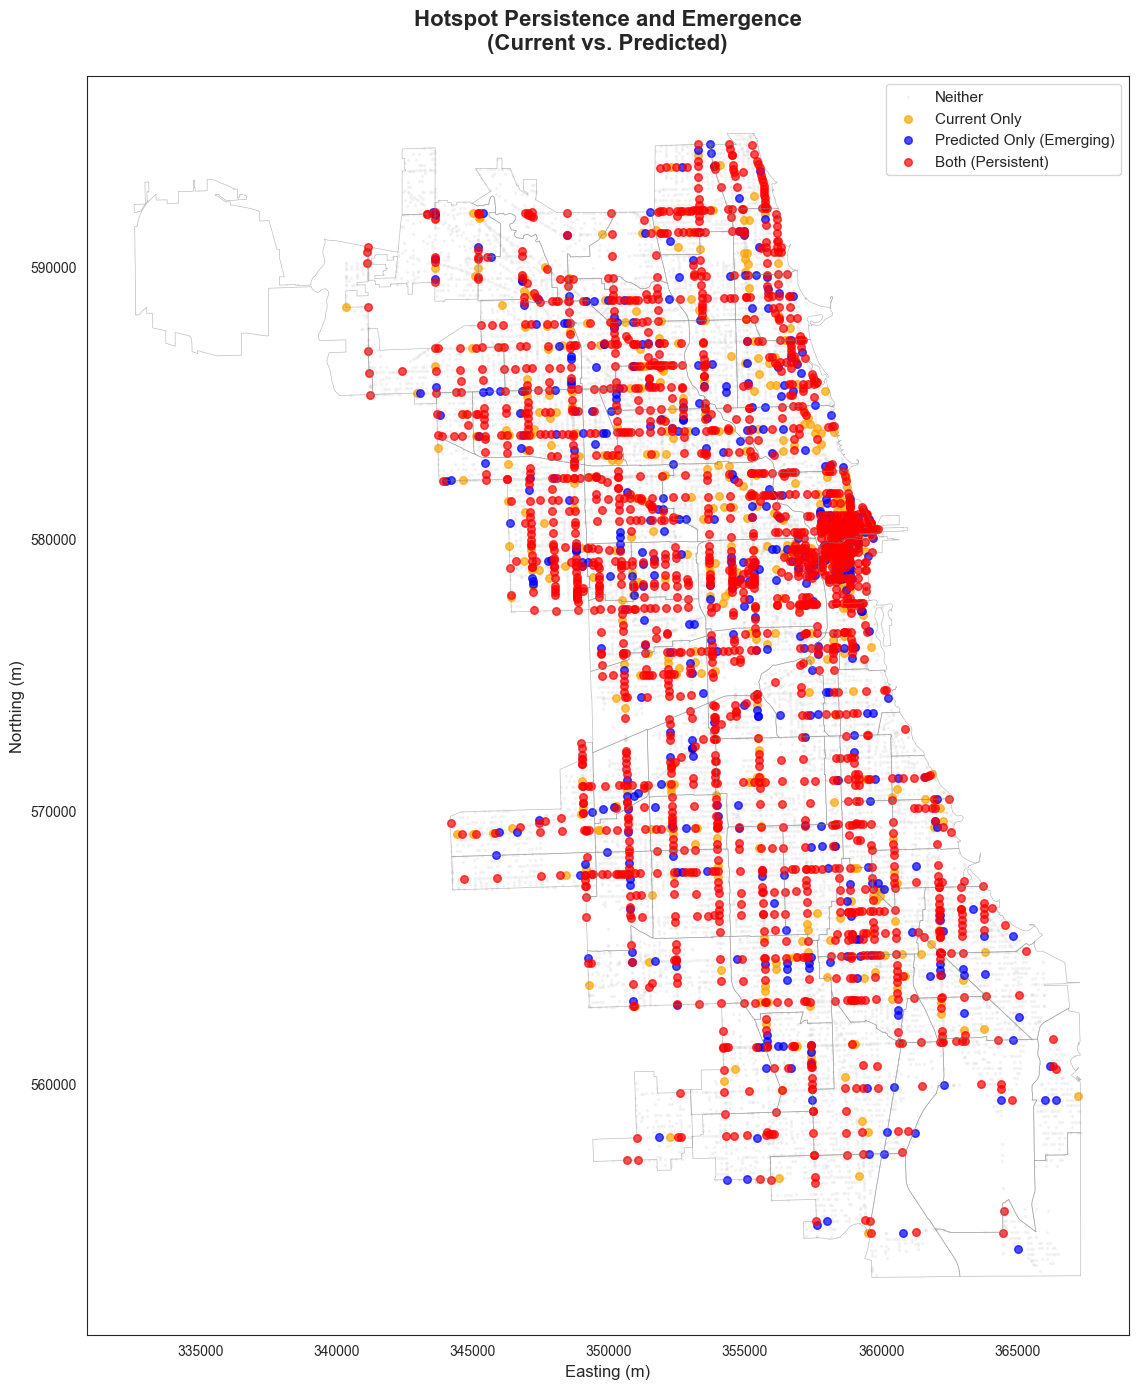

In [17]:
# Analyze agreement between current and predicted hotspots
gdf_with_predictions['agreement'] = 'Neither'
gdf_with_predictions.loc[
    (gdf_with_predictions['label_hotspot'] == 1) & 
    (gdf_with_predictions['predicted_hotspot'] == 1), 
    'agreement'
] = 'Both (Persistent)'
gdf_with_predictions.loc[
    (gdf_with_predictions['label_hotspot'] == 1) & 
    (gdf_with_predictions['predicted_hotspot'] == 0), 
    'agreement'
] = 'Current Only'
gdf_with_predictions.loc[
    (gdf_with_predictions['label_hotspot'] == 0) & 
    (gdf_with_predictions['predicted_hotspot'] == 1), 
    'agreement'
] = 'Predicted Only (Emerging)'

# Summary
print("="*80)
print("HOTSPOT AGREEMENT ANALYSIS")
print("="*80)
agreement_counts = gdf_with_predictions['agreement'].value_counts()
for category, count in agreement_counts.items():
    pct = count / len(gdf_with_predictions) * 100
    print(f"{category:30s}: {count:6,} ({pct:5.2f}%)")

# Visualize agreement
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

if HAS_BOUNDARIES:
    community_boundaries.boundary.plot(ax=ax, linewidth=0.5, edgecolor='gray', alpha=0.5)

colors = {
    'Neither': 'lightgray',
    'Current Only': 'orange',
    'Predicted Only (Emerging)': 'blue',
    'Both (Persistent)': 'red'
}

for category, color in colors.items():
    subset = gdf_with_predictions[gdf_with_predictions['agreement'] == category]
    size = 2 if category == 'Neither' else 30
    alpha = 0.2 if category == 'Neither' else 0.7
    subset.plot(ax=ax, markersize=size, color=color, alpha=alpha, label=category)

ax.set_title('Hotspot Persistence and Emergence\n(Current vs. Predicted)',
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)
ax.legend(loc='upper right', fontsize=11)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'map_hotspot_agreement.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: results/map_hotspot_agreement.png")
plt.show()

## 8. Save Geographic Analysis Results

In [18]:
# Save agreement analysis
agreement_summary = gdf_with_predictions['agreement'].value_counts().reset_index()
agreement_summary.columns = ['category', 'count']
agreement_summary['percentage'] = agreement_summary['count'] / len(gdf_with_predictions) * 100
agreement_summary.to_csv(RESULTS_DIR / 'hotspot_agreement_summary.csv', index=False)

# Save persistent hotspots (both current and predicted)
persistent = gdf_with_predictions[gdf_with_predictions['agreement'] == 'Both (Persistent)'][[
    'intersection_id', 'hist_crashes', 'future_crashes', 'predicted_probability',
    'community_name', 'geometry'
]].copy()
# Extract x, y from geometry
persistent['x'] = persistent.geometry.x
persistent['y'] = persistent.geometry.y
persistent = persistent.drop(columns=['geometry'])
persistent.to_csv(RESULTS_DIR / 'persistent_hotspots.csv', index=False)

# Save emerging hotspots (predicted but not current)
emerging = gdf_with_predictions[gdf_with_predictions['agreement'] == 'Predicted Only (Emerging)'][[
    'intersection_id', 'hist_crashes', 'predicted_probability',
    'community_name', 'geometry'
]].copy()
# Extract x, y from geometry
emerging['x'] = emerging.geometry.x
emerging['y'] = emerging.geometry.y
emerging = emerging.drop(columns=['geometry'])
emerging.to_csv(RESULTS_DIR / 'emerging_hotspots.csv', index=False)

print("\n✅ All geographic visualization results saved to results/ directory")
print("   Maps:")
print("   - map_current_hotspots.png")
print("   - map_predicted_hotspots.png")
print("   - map_community_choropleth.png")
print("   - map_comparison_current_vs_predicted.png")
print("   - map_hotspot_agreement.png")
print("\n   Data:")
print("   - hotspot_agreement_summary.csv")
print("   - persistent_hotspots.csv")
print("   - emerging_hotspots.csv")


✅ All geographic visualization results saved to results/ directory
   Maps:
   - map_current_hotspots.png
   - map_predicted_hotspots.png
   - map_community_choropleth.png
   - map_comparison_current_vs_predicted.png
   - map_hotspot_agreement.png

   Data:
   - hotspot_agreement_summary.csv
   - persistent_hotspots.csv
   - emerging_hotspots.csv


## Summary

This notebook created publication-quality geographic visualizations:

1. **Current Hotspot Map** - Shows where crashes are concentrated historically
2. **Predicted Hotspot Map** - Model-based future risk assessment
3. **Community Choropleth** - Crash burden by neighborhood
4. **Comparison Maps** - Current vs. predicted side-by-side
5. **Agreement Analysis** - Persistent vs. emerging hotspots

### For Your Paper:
Use these maps in your **Results** section to:
- Show spatial distribution of crashes
- Demonstrate model predictions
- Highlight inequality across communities
- Identify priority areas for intervention